Introduction
====

In this notebook I will continue the analysis from my [previous notebook](https://github.com/dstuerzer/Kaggle/blob/master/credit_card_fraud/Optimization%20of%20Logistic%20Regression.ipynb), in which I have discussed the pecularities of highly imbalanced datasets, and tried to optimize a Logistic Regression to predict frauds. Even though the results were quite satisfactory, still better models can be found. Here I will discuss the application of the very popular XGBoost method. It will indeed significantly improve the prediction accuracy. 

The analysis is based on this [Kaggle dataset](https://www.kaggle.com/dalpozz/creditcardfraud).

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.grid_search import GridSearchCV
import itertools
import plot_confusion as pc

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


We read the data, and split it into the data (X_, y_) (with underscores), which will be used to optimize the parameters and train our final model. This will then be validated on the test set (X_test, y_test).

In [2]:
df = pd.read_csv("data/creditcard.csv")
print(df.head(3))
y = np.array(df.Class.tolist())     #classes: 1..fraud, 0..no fraud
df = df.drop('Class', 1)
X = np.array(df.as_matrix())   # features

X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.2)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]


The data consists of 28 numerical features, time, and the amount that was withdrawn.

Strategies
===

Convenient ways to characterize the performance of a classifier here are Fallout and Recall (and the corresponding ROC-curve), and possibly the Precision (check out [Wikipedia](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers) for definitions). In order to find good parameters we might try the following approaches:
* Maximize the Recall for fixed, sufficiently small Fallout.
* Maximize the ROC-AUC. This metric is built in, but might lead to different results than the previous strategy.
* Maximize the F1-score, which is the harmonic mean of Precision and Recall. 
Here, I will compare all three strategies. 

Before we start, it might be useful to recall our goal. Most importantly, we want to maximize the Recall. Undetected frauds are what actually creates costs for the bank and/or the customer. However, if we increase the sensitivity (i.e. the Recall), we also increase the rate of 'false alarms', and this can be very annoying, even though it does not directly generate costs. However, if a customer gets a false fraud alert every week, he or she will consider changing to another bank. Keeping false alarms small means keeping the Fallout small, or (almost) equivalently, keeping the Precision high. Hence, we will either:
* Find a tradeoff between high Recall and low Fallout, or
* simply maximize the F1-score, therefore 'maximizing' Precision and Recall at the same time.

Grid Search - Maximizing the F1-Score
===

That is our first approach.

In [3]:
cv_params = {'max_depth': [1,2,3,4,5,6], 'min_child_weight': [1,2,3,4]}    # parameters to be tries in the grid search
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic'}   #other parameters, fixed for the moment 
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)

In [4]:
csv.fit(X_, y_)
csv.grid_scores_

[mean: 0.82792, std: 0.01846, params: {'max_depth': 1, 'min_child_weight': 1},
 mean: 0.82792, std: 0.01846, params: {'max_depth': 1, 'min_child_weight': 2},
 mean: 0.83582, std: 0.00651, params: {'max_depth': 1, 'min_child_weight': 3},
 mean: 0.83265, std: 0.01724, params: {'max_depth': 1, 'min_child_weight': 4},
 mean: 0.86195, std: 0.01864, params: {'max_depth': 2, 'min_child_weight': 1},
 mean: 0.86104, std: 0.02238, params: {'max_depth': 2, 'min_child_weight': 2},
 mean: 0.86478, std: 0.02223, params: {'max_depth': 2, 'min_child_weight': 3},
 mean: 0.86289, std: 0.02198, params: {'max_depth': 2, 'min_child_weight': 4},
 mean: 0.85934, std: 0.01993, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.85837, std: 0.01567, params: {'max_depth': 3, 'min_child_weight': 2},
 mean: 0.86614, std: 0.02134, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.86785, std: 0.02579, params: {'max_depth': 3, 'min_child_weight': 4},
 mean: 0.86397, std: 0.02444, params: {'max_depth': 

In [5]:
csv.best_params_

{'max_depth': 5, 'min_child_weight': 3}

We see that the particular choice of min_child_weight does not have a significant impact on the F1-score. Let's still pick the best results of this search, i.e., max_depth = 5, and min_child_weight = 3, and continue the grid search.

In [ ]:
cv_params = {'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight':3}
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5) 
csv.fit(X_, y_)
csv.best_params_

In [ ]:
csv.grid_scores_

Finally we search for an optimal leaning rate:

In [11]:
cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}
fix_params['max_delta_step'] = 1
fix_params['subsample'] = 0.8
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5) 
csv.fit(X_, y_)
csv.grid_scores_

[mean: 0.84470, std: 0.02816, params: {'learning_rate': 0.05},
 mean: 0.86378, std: 0.02592, params: {'learning_rate': 0.1},
 mean: 0.86620, std: 0.03025, params: {'learning_rate': 0.15},
 mean: 0.87332, std: 0.02759, params: {'learning_rate': 0.2},
 mean: 0.86555, std: 0.02970, params: {'learning_rate': 0.25},
 mean: 0.86722, std: 0.02474, params: {'learning_rate': 0.3}]

In [12]:
csv.best_params_

{'learning_rate': 0.2}

Unfortunately, running the same grid search again often yields different 'optimal' parameters. We settle for the rate 0.2, and here are our final parameters (if we wanted, we could rerun the grid searches another time, but I believe that the gain will be minimal compared to the associated computational costs. 

In [13]:
fix_params['learning_rate'] = 0.2
params_final =  fix_params
print(params_final)

{'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 4, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}


Now we train our final model on the entire training set, and evaluate it on the still unused testing set:

In [26]:
xgdmat_train = xgb.DMatrix(X_, y_)
xgdmat_test = xgb.DMatrix(X_test, y_test)
xgb_final = xgb.train(params_final, xgdmat_train, num_boost_round = 100)

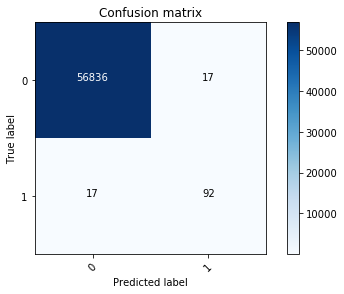

Precision =     0.844
Recall (TPR) =  0.844
Fallout (FPR) = 2.990e-04


In [29]:
y_pred = xgb_final.predict(xgdmat_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
pc.plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = pc.show_data(cm, print_res = 1);

We can still play around with the probability threshold, such that Precision and Recall are to our liking. As far as we can tell from the evaluation of the final model on the testing set, it seems at least comparable to the Logistic Regression.

Grid Search - ROC-AUC
===

We can repeat exactly the same reasoning, just with scoring = 'roc_auc' in the CV. Indeed, we get similiar near-optimal parameters. I do not show this here.

Maximized Recall for given Fallout
===

Here I will apply a similar strategy to the one described in my previous notebook about the Logistic Regression. I will repeat CV multiple times in order to get averaged, precise ROC-curves and Precision-Recall-curves (PR). If we specify a Fallout or a desired Precision, we can use the curves to find the optimal parameters such that the Recall is then maximized. Since I will average over many curves, this is a very precise approach, but it is bound to be very computation-intensive.

Let us specify the XGBoost-parameters we for now assume best, e.g. the ones we have obtained above.

In [21]:
par = params_final

The following function splits the training data into a further training and a valuation set, and generates the ROC- and the PR-curve based on the valuation data:

In [22]:
def get_curves(X_, y_, pars):
    X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size = 0.2)
    clf = xgb.XGBClassifier(**pars)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_val)[:,clf.classes_[1]]
    fpr, tpr, thresholds_roc = roc_curve(y_val, y_prob)
    prec, rec, thresholds_pr = precision_recall_curve(y_val, y_prob)
    return fpr, tpr, prec, rec

This function now calls 'get_curves' *N_iter* times and computes averaged ROC- and PR-curves:

In [30]:
def gen_curves(X_, y_, pars):
    N_iter = 100
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100000)
    
    mean_prec = 0.0
    mean_rec = np.linspace(0, 1, 100000)
    
    for n in range(N_iter):
        fpr, tpr, prec, rec = get_curves(X_, y_, pars)
        prec = list(reversed(prec)) #reverse, otherwise the interp doesn not work
        rec = list(reversed(rec))
        mean_tpr  += np.interp(mean_fpr, fpr, tpr)
        mean_prec += np.interp(mean_rec, rec, prec)

    mean_tpr /= N_iter
    mean_prec /= N_iter
    
    return mean_fpr, mean_tpr, mean_prec, mean_rec


And this function finally plots the curves for different parameters:

In [31]:
def plot_roc(X_, y_, par, name_par, list_par):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,7));
    for l in list_par:
        par[name_par] = l
        print(par)
        mean_fpr, mean_tpr, mean_prec, mean_rec = gen_curves(X_, y_, par)
        ax1.plot(mean_fpr, mean_tpr, label = name_par+" = "+str(l))
        ax2.plot(mean_rec, mean_prec, label = name_par+" = "+str(l))
    ax1.set_xlim([0, 0.0005])
    ax1.set_ylim([0.5, 0.95])
    ax1.axvline(2e-4, color='b', linestyle='dashed', linewidth=2)
    ax1.legend(loc="lower right")
    ax1.set_xlabel('FPR/Fallout')
    ax1.set_ylabel('TPR/Recall')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax1.set_title('ROC')
    ax2.set_title('PR')
    ax2.legend(loc = "lower left")
    ax2.set_xlim([0.5, 1])
    plt.show()

Let us first vary 'max_depth'. The vertical line in the ROC-curve is a Fallout we would like to achieve, and the parameter for which the corresponding Recall is maximzed is the one we pick:

{'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 1, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}
{'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 2, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}
{'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}
{'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 4, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}
{'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}
{'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 7, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}
{'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 

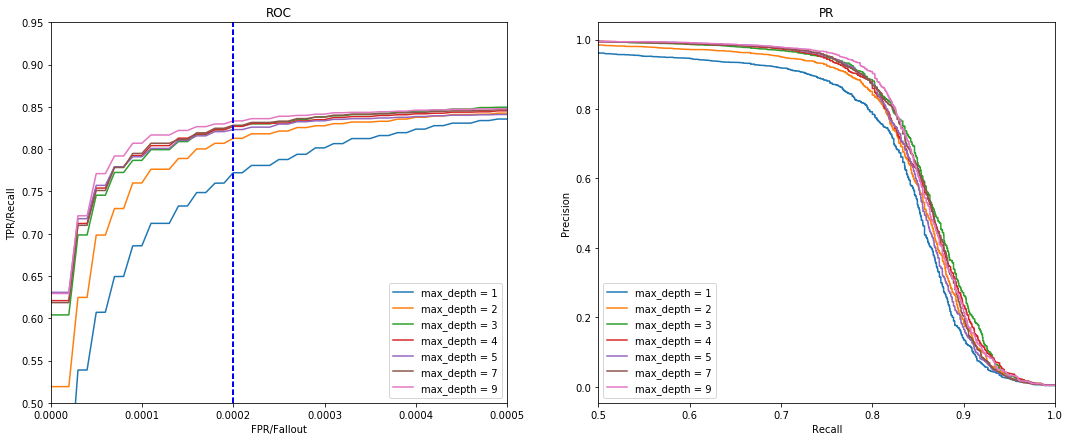

In [34]:
plot_roc(X_, y_, par, 'max_depth', [1,2,3,4,5,7,9])

{'learning_rate': 0.25, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 7, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}
{'learning_rate': 0.25, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 9, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}
{'learning_rate': 0.25, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 12, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}
{'learning_rate': 0.25, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 15, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}
{'learning_rate': 0.25, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 20, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}


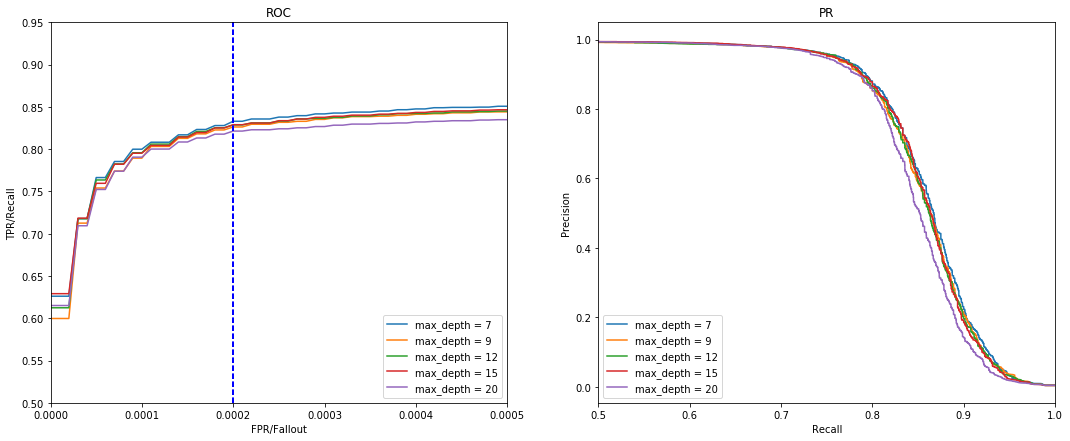

In [36]:
plot_roc(X_, y_, par, 'max_depth', [7,9,12,15,20])

In the second round max_depth = 7 is now slightly better than max_depth = 9. The bottom line from the above grid searches is that (at least for an iteration number of 100) any max_depth $\ge$ 4 does not show any significant improvement any more; for much larger max_depth-values the quality of the model seems even to get worse! Therefore, we will settle for max_depth =5. We set the obtained quasi-optimal parameter 'max_depth', and now vary the learning rate:

{'learning_rate': 0.05, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}
{'learning_rate': 0.1, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}
{'learning_rate': 0.15, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}
{'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}
{'learning_rate': 0.25, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 3, 'max_delta_step': 1, 'subsample': 0.8}


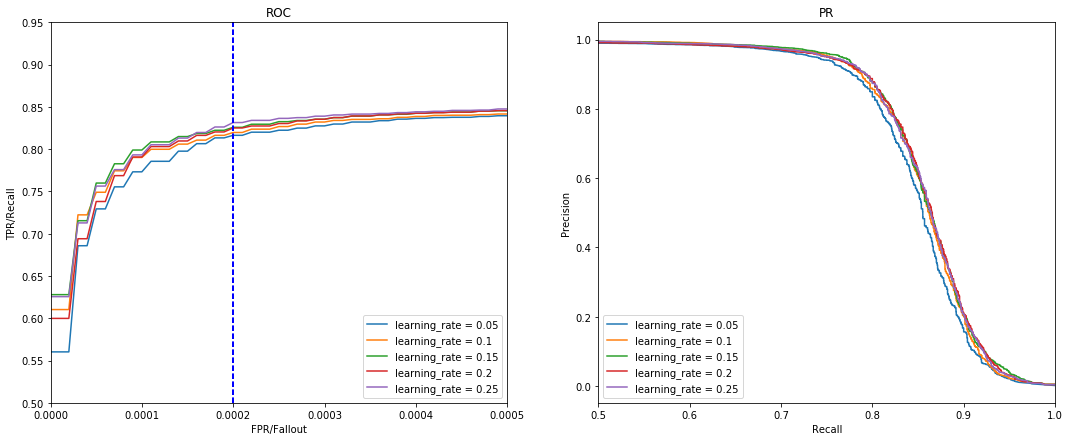

In [37]:
par['max_depth'] = 5
plot_roc(X_, y_, par, 'learning_rate', [0.05,0.1,0.15,0.2,0.25])

In the F1-cross we have observed that it was mostly those two parameters that had an influence on the performance of the model. This suggests we stop here, and fix (or keep) our final parameters.

In [40]:
par['learning_rate'] = 0.25

We now train the final model on the full training set (X_, y_) and apply to the still untouched testing set (X_test, y_test).

In [41]:
xgdmat_train = xgb.DMatrix(X_, y_)
xgdmat_test = xgb.DMatrix(X_test, y_test)
xgb_final = xgb.train(par, xgdmat_train, num_boost_round = 100)
y_pred = xgb_final.predict(xgdmat_test)
print(y_pred[:4])
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)
prec, rec, thresholds_pr = precision_recall_curve(y_test, y_pred)

mean_fpr = np.linspace(0, 1, 100000)
mean_rec = np.linspace(0, 1, 1000)

prec = list(reversed(prec)) #reverse, otherwise the interp doesn not work
rec = list(reversed(rec))
mean_tpr = np.interp(mean_fpr, fpr, tpr)
mean_prec = np.interp(mean_rec, rec, prec)


[  6.93985703e-06   2.41562088e-06   1.46268678e-06   3.99529345e-05]


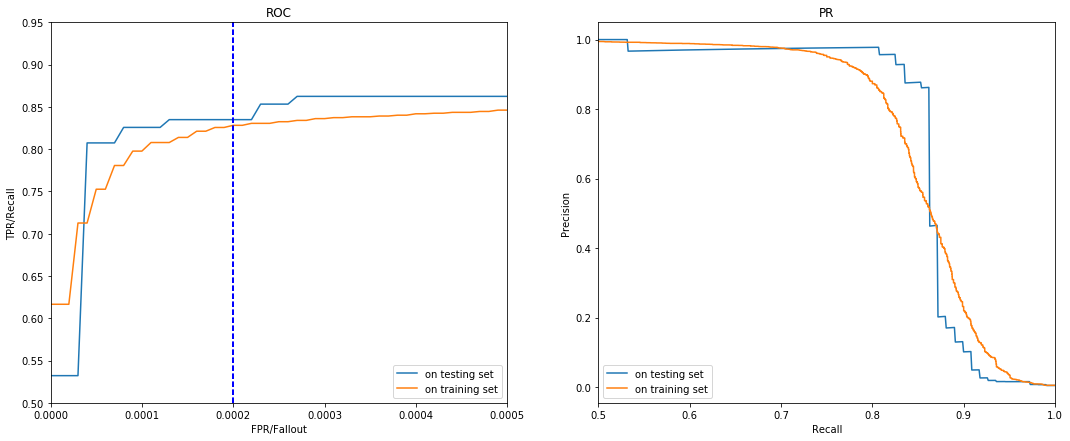

In [42]:
mean_fpr2, mean_tpr2, mean_prec2, mean_rec2 = gen_curves(X_, y_, par)   #the averaged curves from the training set as comparison

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,7));
ax1.plot(mean_fpr, mean_tpr, label = 'on testing set');
ax1.plot(mean_fpr2, mean_tpr2, label = 'on training set');

ax2.plot(mean_rec, mean_prec, label = 'on testing set');
ax2.plot(mean_rec2, mean_prec2, label = 'on training set');

ax1.set_xlim([0, 0.0005])
ax1.set_ylim([0.5, 0.95])
ax1.axvline(2e-4, color='b', linestyle='dashed', linewidth=2)
ax1.set_xlabel('FPR/Fallout')
ax1.set_ylabel('TPR/Recall')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax1.set_title('ROC')
ax2.set_title('PR')
ax2.set_xlim([0.5, 1])
ax1.legend(loc="lower right")
ax2.legend(loc = 'lower left')
plt.show()

Above we see the ROC- and the PR-curve for our model on the testing set, and as a comparison, the smoothed curves obtained by repeated cross-validation on the training set. We see that on the training set our XGBoost-model performs better than the Logistic Regression (compare to my previous notebook): For a fixed Fallout of 2e-4 the (average) Recall is about 5% higher. On the testing set we expect higher fluctuations, but nevertheless, the model performs well there too.

The prediction vector *y_pred* contains now probabilities for the classes. By varying the threshold, we obtain the ROC- and PR-curves, and can adapt the sensitivity of the model to our liking (having an eye on the curves, so we know what we can expect).

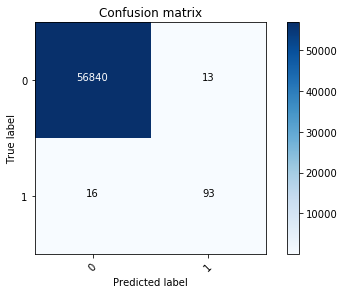

Precision =     0.877
Recall (TPR) =  0.853
Fallout (FPR) = 2.287e-04


In [43]:
y_final = np.copy(y_pred)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
pc.plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = pc.show_data(cm, print_res = 1);

Unfortunately, we have to expect a high variation in the testing results, since the testing set only contains very few frauds. The averaged ROC- and PR-curves might still be a better indication on the actual quality of the model.

One of the main lessons of this analysis is that XGBoost will (on average) outperform the Logistic Regression, and is more suited to predict frauds. In particular, the ROC-curve is much steeper around the origin, and we can achieve similar Recall rates with only half of the Fallout (i.e. a Fallout of ~80% with a Recall of just 1e-4).